In [69]:
# Choose a random number of 6 digits. Make sure that you keep a copy of this number and avoid trivial numbers, such as 000000 or 123456 -- thank you!
972972

972972

# Assignment 1 - Visualisation and Performance Evaluation

First assessed coursework for the course: Técnicas e Algoritmos em Ciência de Dados 

## General guidelines:

* This work must be entirely original. You are allowed to research documentation for specific libraries, but copying solutions from the internet or your classmates is strictly prohibited. Any such actions will result in a deduction of points for the coursework.
* Please enter your code in the designated areas of the notebook. You can create additional code cells to experiment with, but __make sure to place your final solutions where they are requested in the notebook.__
* The notebook already imports all the necessary libraries for this assignment at the beginning. Although you are allowed to import other libraries, it is not necessary.
* Before submitting your work, make sure to rename the file to your random number that you created above (for example, 289479.ipynb).
* Please try to not use AI tools, such as ChatGPT, Copilot, Gemini, etc., this work is designed for you to get familiarized with important concepts that require hands-on experience.

## Notebook Overview:

1. [Data Loading and Visualisation](#Data-Loading-and-Visualisation) (20%)
2. [Binary Classification Building a ROC curve](#Binary-Classification-Building-a-ROC-curve) (50%)
3. [Regression RMSE](#Regression-RMSE) (30%)

In [70]:
%matplotlib inline
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

## Data Loading and Visualisation

* Load the Iris dataset that you downloaded from the following link: https://www.kaggle.com/datasets/uciml/iris/download?datasetVersionNumber=2
* __Important:__ to ensure proper execution of your code, you need to either place the downloaded .csv file in the same working directory as the program or specify the correct path to the file.
* Load the data into a pandas `DataFrame`
* For each feature in the dataset, create a figure with two subplots one on top of the other.
    * In the first subplot, plot a histogram of the values of the feature for all classes combined. 
    * In the second subplot, plot a histogram of the values of the feature for each class separately. Use the column “Species” as the class identifier, and a different color for each class. 
    

* __Note:__ the data contains a column "Id" that you can ignore. 

In [71]:
# Load the data
# your code goes here

iris_df = pd.read_csv('Iris.csv')

iris_df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


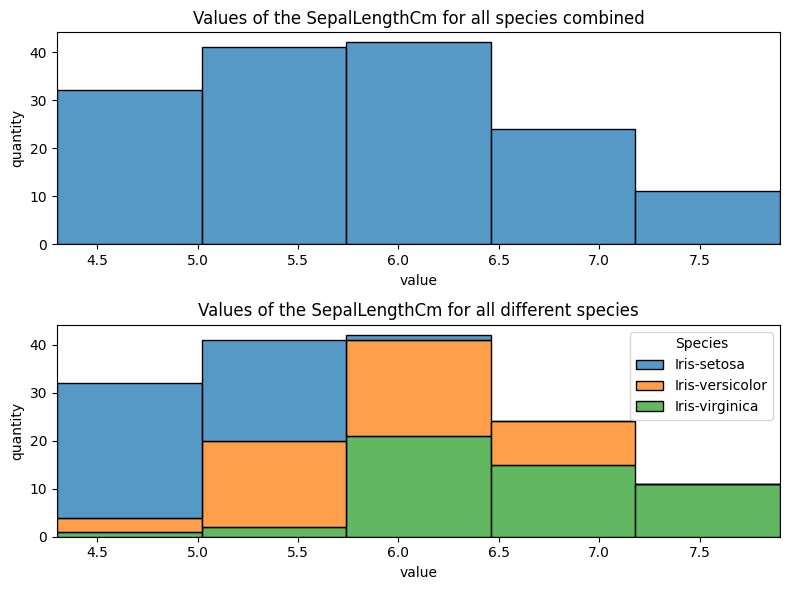

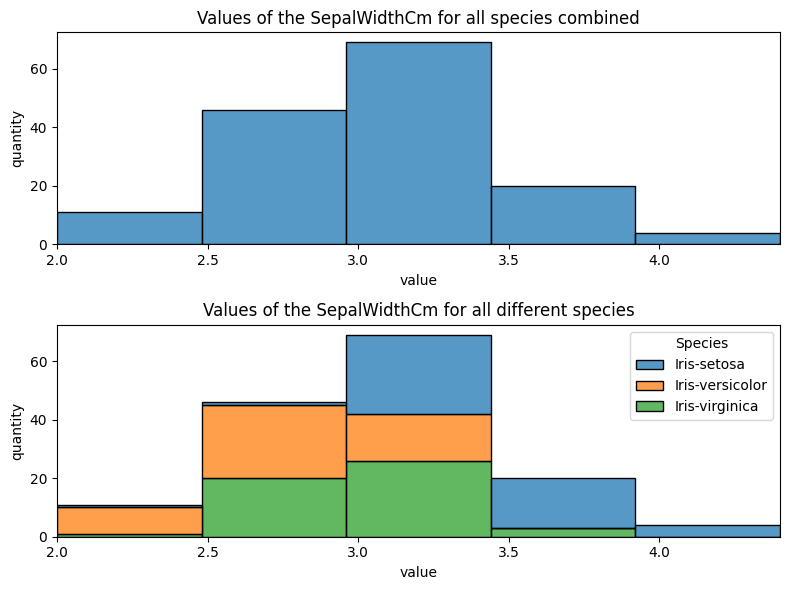

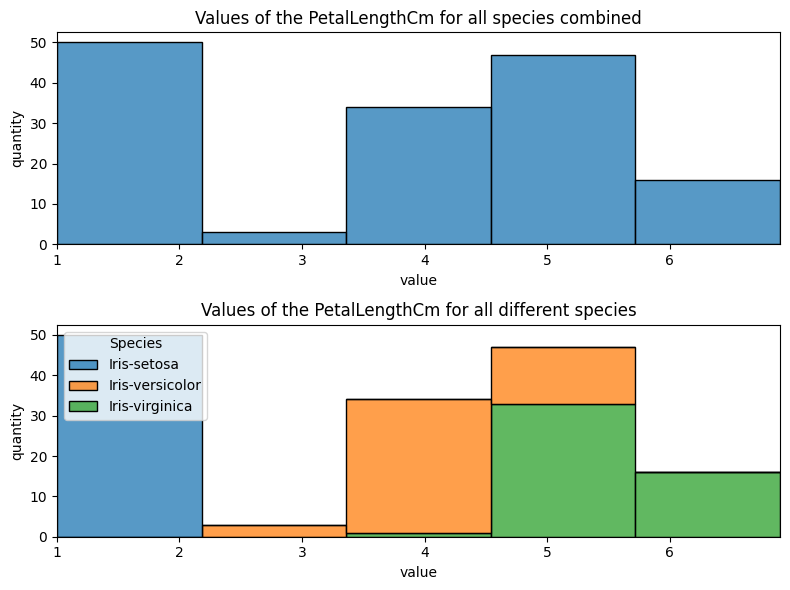

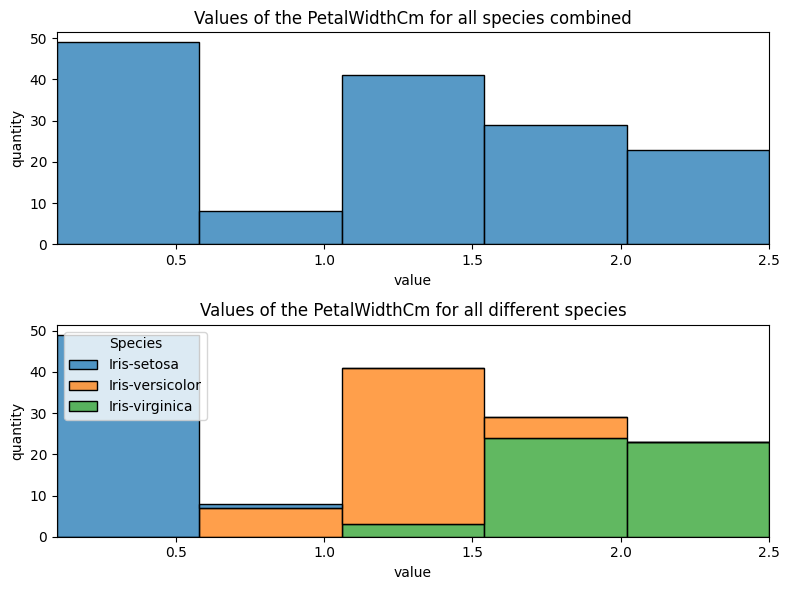

In [72]:
# The code for your plots go here

features = iris_df.iloc[:, 1:-1] # goes through all lines and through column 2 up to penultimate

for feature in features:
    values = iris_df[feature].values
    max_value = max(values)
    min_value = min(values)
    
    fig, axs = plt.subplots(2, 1, figsize=(8,6))

    # first graph
    sns.histplot(iris_df[feature], bins=5, ax=axs[0]) # bins=5 makes the lenght of bar = 0.72
    axs[0].set_title(f"Values of the {feature} for all species combined")
    axs[0].set_xlabel("value")
    axs[0].set_ylabel("quantity")
    axs[0].set_xlim(min_value, max_value)

    # second graph
    sns.histplot(iris_df, bins=5, x=feature, hue="Species", multiple="stack", ax=axs[1])
    axs[1].set_title(f"Values of the {feature} for all different species")
    axs[1].set_xlabel("value")
    axs[1].set_ylabel("quantity")
    axs[1].set_xlim(min_value, max_value)

    # tests:
    # count_on_certain_bin = (values < 5.02).sum()
    # print(count_on_certain_bin)

    # sns.countplot(iris_df, )


    plt.tight_layout()
    plt.show()



## Binary Classification Building a ROC curve

The goal of this exercise is to evaluate the performance of various pre-trained classification models in predicting whether a mushroom is edible or poisonous. To achieve this, we will generate ROC curves for each algorithm and determine the area under the curve. Using these metrics, we will decide which classifier is best suited for the task.

Follow the instructions in the cells below to complete this task.

In [73]:
# Loading the pre-trained classifiers and testing data
classifiers = pkl.load(open('classifiers_dict.p','rb'))
mushroom_test_data = pkl.load(open('mushroom_test_data.p','rb'))

The loaded variables are dictionaries. One contains the pre-trained classifiers and the other one the testing data. 

Let's inspect the contents of the classifiers_dict

In [74]:
classifiers

{'Categorical NB': CategoricalNB(),
 'Logistic Regression': LogisticRegression(max_iter=600),
 'SVM': SVC(probability=True),
 'Gradient Boosting': GradientBoostingClassifier()}

* We can see that the key is the name of the classifier and the value contains the pre-trained instance of each classifier. 
* In the next code cell there's code to extract the classifiers into separate variables.

In [75]:
cnb_clf = classifiers['Categorical NB']
lr_clf = classifiers['Logistic Regression']
svm_clf = classifiers['SVM']
gb_clf = classifiers['Gradient Boosting']

Next we'll extract the testing data from the mushroom_test_data dictionary we just loaded.

First, let's inspect the keys of the dictionary (we don't look at the values because the data is rather large and we don't want it to take up the whole screen).

In [76]:
mushroom_test_data.keys()

dict_keys(['X_test', 'y_test'])

* X_test contains the data points with their features that will serve as the input to our trained models.
* y_test contains the true labels for the testing set, which we'll use to evaluate our predictions.

In [77]:
X_test = mushroom_test_data['X_test']
y_test = mushroom_test_data['y_test']

As we can see below, X_test contains the 21 features that were used to train the different classifiers. 
* __Note__ that the index is shuffled because this is a random subset of the original data that we are using as our testing set.

In [78]:
X_test.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
700,5,2,4,1,6,1,0,1,10,0,...,2,2,7,7,2,1,4,2,3,1
6743,2,2,2,0,8,1,0,1,0,1,...,1,2,6,6,2,1,0,7,4,0
1571,5,0,8,0,5,1,1,0,4,1,...,2,0,7,7,2,1,0,2,0,1
5949,5,3,4,0,5,1,1,1,10,0,...,0,2,7,4,2,1,0,7,4,2
3307,2,3,4,1,5,1,0,0,5,1,...,2,2,7,6,2,1,4,3,5,0


During class we looked at the case where the output of the classifier is a number between 0 and 1. This is the case for the classifiers we will use here. For these classifiers this output can be interpreted as the probabilities.

We are now going to obtain the predicted probabilities from our different classifiers
* To do this we are using the method `predict_proba()`
* This is a method specific to each classifier and it requires as input argument the datapoints of our testing set with their features (`X_test`).

In [79]:
y_proba_cnb = cnb_clf.predict_proba(X_test)
y_proba_svm = svm_clf.predict_proba(X_test)
y_proba_lr = lr_clf.predict_proba(X_test)
y_proba_gb = gb_clf.predict_proba(X_test)

Let's inspect one of the variables we just created. 

We notice that it contains two values per row that sum up to 1. The first value is the probability of class 0 and the second value is the probability of class 1.

__For this exercise, you will use only the second column (probability of class 1) as was explained in class.__

In [80]:
y_proba_cnb

array([[0.65196915, 0.34803085],
       [0.23215623, 0.76784377],
       [0.59078654, 0.40921346],
       ...,
       [0.71358323, 0.28641677],
       [0.63896396, 0.36103604],
       [0.68272357, 0.31727643]], shape=(1625, 2))

## Calculating the false positive and true positive rates
Now that we have our predicted values and the true labels, we are ready to calculate the ROC curve

Feel free to define the function(s) in a way that you find most comfortable. The goal of these functions is to generate the False Positive Rates (FPRs) and True Positive Rates (TPRs) at different thresholds for all classifiers.

The cell below contains a suggestion on how you can structure the function -- you can also do it differently if you prefer.

In [81]:
# The following is just example code, it is not meant to be executed.
def get_fpr_tpr(predicted_values, true_labels, threshold):
    # body of the function
    return fpr, tpr
# this function would calculate the confusion matrix and then the fpr and tpr and return it as two separate values. 

# to then use the output values of this function you would do something like:
fpr, tpr = get_fpr_tpr(y_proba_lr, y_test, threshold)

In [ ]:
# Your code goes here!!

if type(y_test) == pd.Series:
    y_test = y_test.to_numpy() # it was a pd.Series

predicted_cnb = y_proba_cnb[:, 1]
predicted_svm = y_proba_svm[:, 1]
predicted_lr = y_proba_lr[:, 1]
predicted_gb = y_proba_gb[:, 1]

def get_FPR_TPR(prediction: np.ndarray, true_values: np.ndarray, threshold_prediction: int =0.5):

    prediction = (prediction >= threshold_prediction).astype(int) # returns array classified according to threshold
    
    fp = 0
    tp = 0
    fn = 0
    tn = 0
    for i in range(len(prediction)):
        if prediction[i] == 1 and true_values[i] == 1:
            tp +=1
        elif prediction[i] == 0 and true_values[i] == 1:
            fn +=1
        elif prediction[i] == 1 and true_values[i] == 0:
            fp +=1
        elif prediction[i] == 0 and true_values[i] == 0:
            tn +=1
    
    p1 = np.sum(true_values == 1)
    p2 = fn + tp # these are the same
    n1 = np.sum(true_values == 0)
    n2 = fp + tn

    fpr = fp / n1
    tpr = tp / p1


    return fpr, tpr


## Plotting the ROC curve
Now let's use the calculated FPRs and TPRs to plot the ROC curves for the different classifiers, using `plt` from matplotlib

The template below provides the typical structure of a superimposed plot, but you're welcome to modify it to fit your needs.

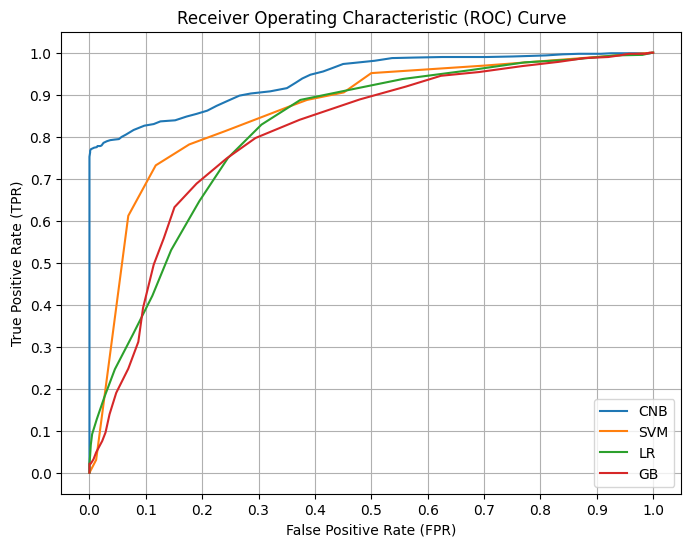

In [ ]:
# Here you must complete the calls to plt.plot() with the right input arguments
# Following that you will need to generate the correct plot properties below
fig = plt.figure(figsize=(8,6))

thresholds = np.arange(0, 1, 0.01) # seeting to 100 thresholds


# ROC Curve for the Categorical Naive Bayes
fpr_cnb_list = []
tpr_cnb_list = []
for threshold in thresholds:
    fpr, tpr = get_FPR_TPR(predicted_cnb, y_test, threshold)
    fpr_cnb_list.append(fpr)
    tpr_cnb_list.append(tpr)

plt.plot(fpr_cnb_list, tpr_cnb_list, label='CNB')


# ROC Curve for SVM
fpr_svm_list = []
tpr_svm_list = []
for threshold in thresholds:
    fpr, tpr = get_FPR_TPR(predicted_svm, y_test, threshold)
    fpr_svm_list.append(fpr)
    tpr_svm_list.append(tpr)
    
plt.plot(fpr_svm_list, tpr_svm_list, label='SVM')


# ROC Curve for Logistic Regression
fpr_lr_list = []
tpr_lr_list = []
for threshold in thresholds:
    fpr, tpr = get_FPR_TPR(predicted_lr, y_test, threshold)
    fpr_lr_list.append(fpr)
    tpr_lr_list.append(tpr)

plt.plot(fpr_lr_list, tpr_lr_list, label='LR')


# ROC Curve for Gradient Boosting
fpr_gb_list = []
tpr_gb_list = []
for threshold in thresholds:
    fpr, tpr = get_FPR_TPR(predicted_gb, y_test, threshold)
    fpr_gb_list.append(fpr)
    tpr_gb_list.append(tpr)
    
plt.plot(fpr_gb_list, tpr_gb_list, label='GB')

# Plot properties
# Title
plt.title("Receiver Operating Characteristic (ROC) Curve")

# X-Ticks and X-label 
plt.xlabel("False Positive Rate (FPR)")
plt.xticks(np.arange(0, 1.1, 0.1))

# Y-Ticks and Y-label
plt.ylabel("True Positive Rate (TPR)")
plt.yticks(np.arange(0, 1.1, 0.1))

# Legend
plt.legend()
plt.grid()

plt.show()

# This next task is worth 10% of the marks

Plot using a single call to a plotting function.
* _Tip: use pandas and seaborn for this_

**This part is not optional or for extra marks, if you finished the previous exercise (plotting with matplotlib), you still have to do this task if you want full points.**

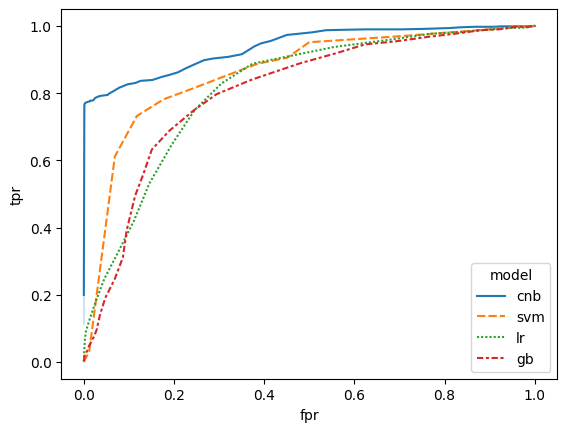

In [84]:
# Your code goes here

# creating dfs individually and concatenating
df_cnb = pd.DataFrame({'tpr': tpr_cnb_list, 'fpr': fpr_cnb_list, 'model': 'cnb'})
df_svm = pd.DataFrame({'tpr': tpr_svm_list, 'fpr': fpr_svm_list, 'model': 'svm'})
df_lr = pd.DataFrame({'tpr': tpr_lr_list, 'fpr': fpr_lr_list, 'model': 'lr'})
df_gb = pd.DataFrame({'tpr': tpr_gb_list, 'fpr': fpr_gb_list, 'model': 'gb'})

df_roc = pd.concat([df_cnb, df_svm, df_lr, df_gb])

sns.lineplot(df_roc, x='fpr', y='tpr', hue='model', style='model')
plt.show()


## Area under the curve
You are not expected to code a function to calculate the area under the ROC curve. Instead you have to use the provided function: `roc_auc_score()` to obtain this value. 

_Make sure to check the relevant documentation for this sklearn function._
* __Important: remember that we only care about the second column of our predicted probabilities!__

In [86]:
# Fill in your code where necessary
cnb_auroc = roc_auc_score(y_test, predicted_cnb) # your code goes here
print("The AUROC for the Categorical Naive Bayes classifier is: {}".format(cnb_auroc))
svm_auroc = roc_auc_score(y_test, predicted_svm) # your code goes here
print("The AUROC for the SVM classifier is: {}".format(svm_auroc))
lr_auroc = roc_auc_score(y_test, predicted_lr) # your code goes here
print("The AUROC for the Logistic Regression classifier is: {}".format(lr_auroc))
gb_auroc = roc_auc_score(y_test, predicted_gb) # your code goes here
print("The AUROC for the Gradient Boosting classifier is: {}".format(gb_auroc))

The AUROC for the Categorical Naive Bayes classifier is: 0.9378448806739412
The AUROC for the SVM classifier is: 0.8689134912617589
The AUROC for the Logistic Regression classifier is: 0.8135634610775899
The AUROC for the Gradient Boosting classifier is: 0.8047463468054835


After analyzing the ROC curves and calculating the area under the curves, it should be apparent that the Categorical Naive Bayes classifier outperforms the other classifiers and is the most suitable option for this particular problem.

## Regression RMSE

The final exercise of this coursework requires you to calculate the Root Mean Squared Error (RMSE) of a linear regression model that predicts house prices.

In [ ]:
# Load the data and the pre-trained model
boston_testing_data = pkl.load(open('boston_testing_data.p','rb'))
linear_regression_model = pkl.load(open('linear_regression_model.p','rb'))

print(boston_testing_data)
print(linear_regression_model)


{'X_test':         LSTAT     INDUS       NOX   PTRATIO        RM       TAX       DIS  \
477  0.494467  0.646628  0.386074  0.592504  0.288161  0.649259  0.084623   
451  0.365685  0.646628  0.515752  0.592504  0.465515  0.649259  0.105665   
29   0.249074  0.281525  0.273696  0.638489  0.467798  0.206207  0.249008   
0    0.085884  0.067815  0.273696  0.252496  0.455845  0.188979  0.238389   
312  0.243465  0.346041  0.283042  0.480586  0.386444  0.201538  0.144091   
..        ...       ...       ...       ...       ...       ...       ...   
376  0.465960  0.646628  0.462776  0.592504  0.464793  0.649259  0.019389   
90   0.178451  0.108138  0.193914  0.440312  0.436467  0.147037  0.164223   
78   0.256788  0.453446  0.101650  0.500130  0.413290  0.338379  0.302499   
44   0.195389  0.236437  0.121890  0.447138  0.392415  0.084145  0.348901   
350  0.110892  0.028959  0.086668  0.562651  0.445467  0.248767  0.528737   

          AGE  
477  0.679146  
451  0.683835  
29   0.625514  


Again, we extract the testing features and the true values in separate variables. 
* __Important:__ I use different variable names because X_test and y_test are being used for exercise 2. There's no need for this, but just to avoid confusion and to not step on pre-existing variables

In [ ]:
X_test_boston = boston_testing_data['X_test']
y_test_boston = boston_testing_data['y_test']
type(y_test_boston)


pandas.core.series.Series

Let's now obtain the predicted values

In [ ]:
y_predict_lin_reg = linear_regression_model.predict(X_test_boston)
type(y_predict_lin_reg)

numpy.ndarray

## Calculating RMSE
Now you have to write code to calculate the root mean squared error on the testing set for the linear regression model we just loaded.
At the end, just print the RMSE value for verification.
### IMPORTANT:
**Calculate the RMSE by vectorising your code, that is, no loops whatsoever!!**

In [ ]:
# Your code goes here

# UNCOMMENT THIS LINE IF FIRST TIME RUNNING:
# y_test_boston = y_test_boston.to_numpy() # because it was a pd.series and y_predict is an np.ndarray

root_mean_square_error = (y_predict_lin_reg - y_test_boston)
root_mean_square_error = root_mean_square_error ** 2
root_mean_square_error = np.sum(root_mean_square_error)
root_mean_square_error = (root_mean_square_error / len(y_test_boston))**(1/2)

print(root_mean_square_error)

# more efficient way I managed to get after but I'm leaving both here cause I like to see my progress
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print(rmse(y_predict_lin_reg, y_test_boston))

0.1942063375481449
0.1942063375481449
